In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import os

from dredFISH.Design import PNMF
from dredFISH.Utils import basicu
from dredFISH.Utils.__init__plots import * 

import importlib
importlib.reload(PNMF)


<module 'dredFISH.Design.PNMF' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Design/PNMF.py'>

In [2]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'res_dpnmf/v_python'
print(res_dir)
fig_dir = prj_dir + 'figures/'

# data (old)
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_matrix.h5ad'
adata = anndata.read_h5ad(f, backed='r') # library size normed (no log)
# X = np.array(adata.X.todense()).copy() # already library size normalized
# adata

# data (CPM with rep)
scrna_genes_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/smrt_withrep_X_subL5n100.npy'
cell_path        = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/smrt_withrep_X_subL5n100_cells.csv'
clst_path        = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/smrt_withrep_X_subL5n100_y_L5.npy'

/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v_python


In [3]:
# allen scrna matrix (CPM; only 10k genes)
X = np.load(scrna_genes_path, allow_pickle=True).T # cell by gene
cells = pd.read_csv(cell_path)['0'].values
# X.sum(axis=1)
y_l5 = np.load(clst_path, allow_pickle=True)

logX = np.log10(X+1)
X.shape, logX.shape, y_l5.shape, cells.shape

((38200, 10861), (38200, 10861), (38200,), (38200,))

In [4]:
meta = adata.obs.copy()
meta = meta.loc[cells]
meta[['cluster_label', 'subclass_label', 'neighborhood_label', 'class_label']]

,cluster_label,subclass_label,neighborhood_label,class_label
SM-D9CZ6_S01_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
LS-15352_S16_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
SM-D9EPN_S55_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
SM-D9CZK_S30_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
SM-GE676_S016_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
...,...,...,...,...
SM-GE4XX_S291_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic
SM-GE4XV_S182_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic
SM-GE4WM_S007_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic
SM-GE4XV_S189_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic


In [5]:
# get the S matrix
ctrds_l3, types_l3 = basicu.group_mean(X, meta['subclass_label'].values)
print(ctrds_l3.shape)
print(types_l3)

ctrds_l2, types_l2 = basicu.group_mean(X, meta['neighborhood_label'].values)
print(ctrds_l2.shape)
print(types_l2)

ctrds_l1, types_l1 = basicu.group_mean(X, meta['class_label'].values)
print(ctrds_l1.shape)
print(types_l1)

(42, 10861)
['Astro' 'CA1-ProS' 'CA2-IG-FC' 'CA3' 'CR' 'CT SUB' 'Car3' 'DG' 'Endo'
 'L2 IT ENTl' 'L2 IT ENTm' 'L2/3 IT CTX' 'L2/3 IT ENTl' 'L2/3 IT PPP'
 'L2/3 IT RHP' 'L3 IT ENT' 'L4 RSP-ACA' 'L4/5 IT CTX' 'L5 IT CTX' 'L5 PPP'
 'L5 PT CTX' 'L5/6 IT TPE-ENT' 'L5/6 NP CTX' 'L6 CT CTX' 'L6 IT CTX'
 'L6 IT ENTl' 'L6b CTX' 'L6b/CT ENT' 'Lamp5' 'Meis2' 'Micro-PVM' 'NP PPP'
 'NP SUB' 'Oligo' 'Pvalb' 'SMC-Peri' 'SUB-ProS' 'Sncg' 'Sst' 'Sst Chodl'
 'VLMC' 'Vip']
(8, 10861)
['CGE' 'DG/SUB/CA' 'L2/3 IT' 'L4/5/6 IT Car3' 'MGE' 'NP/CT/L6b' 'Other'
 'PT']
(3, 10861)
['GABAergic' 'Glutamatergic' 'Non-Neuronal']


/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


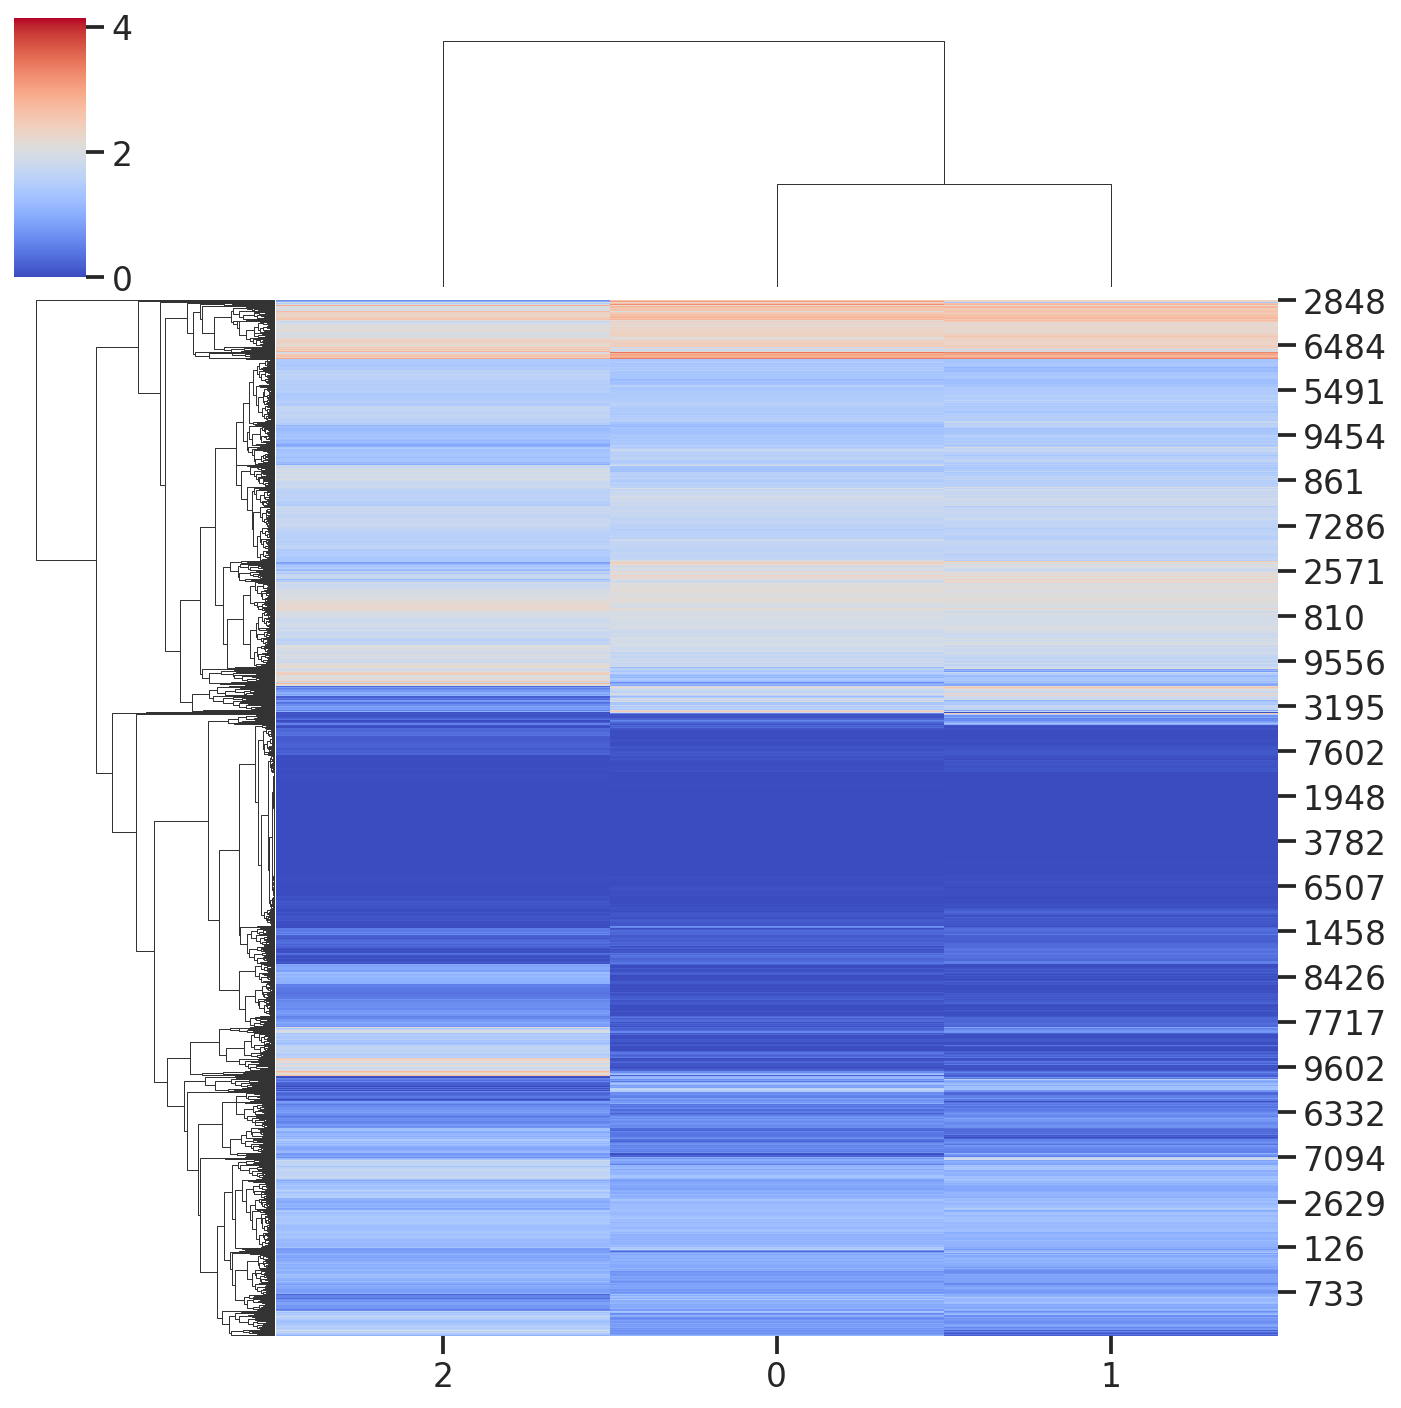

In [6]:
sns.clustermap(np.log10(ctrds_l1.T+1), cmap='coolwarm')

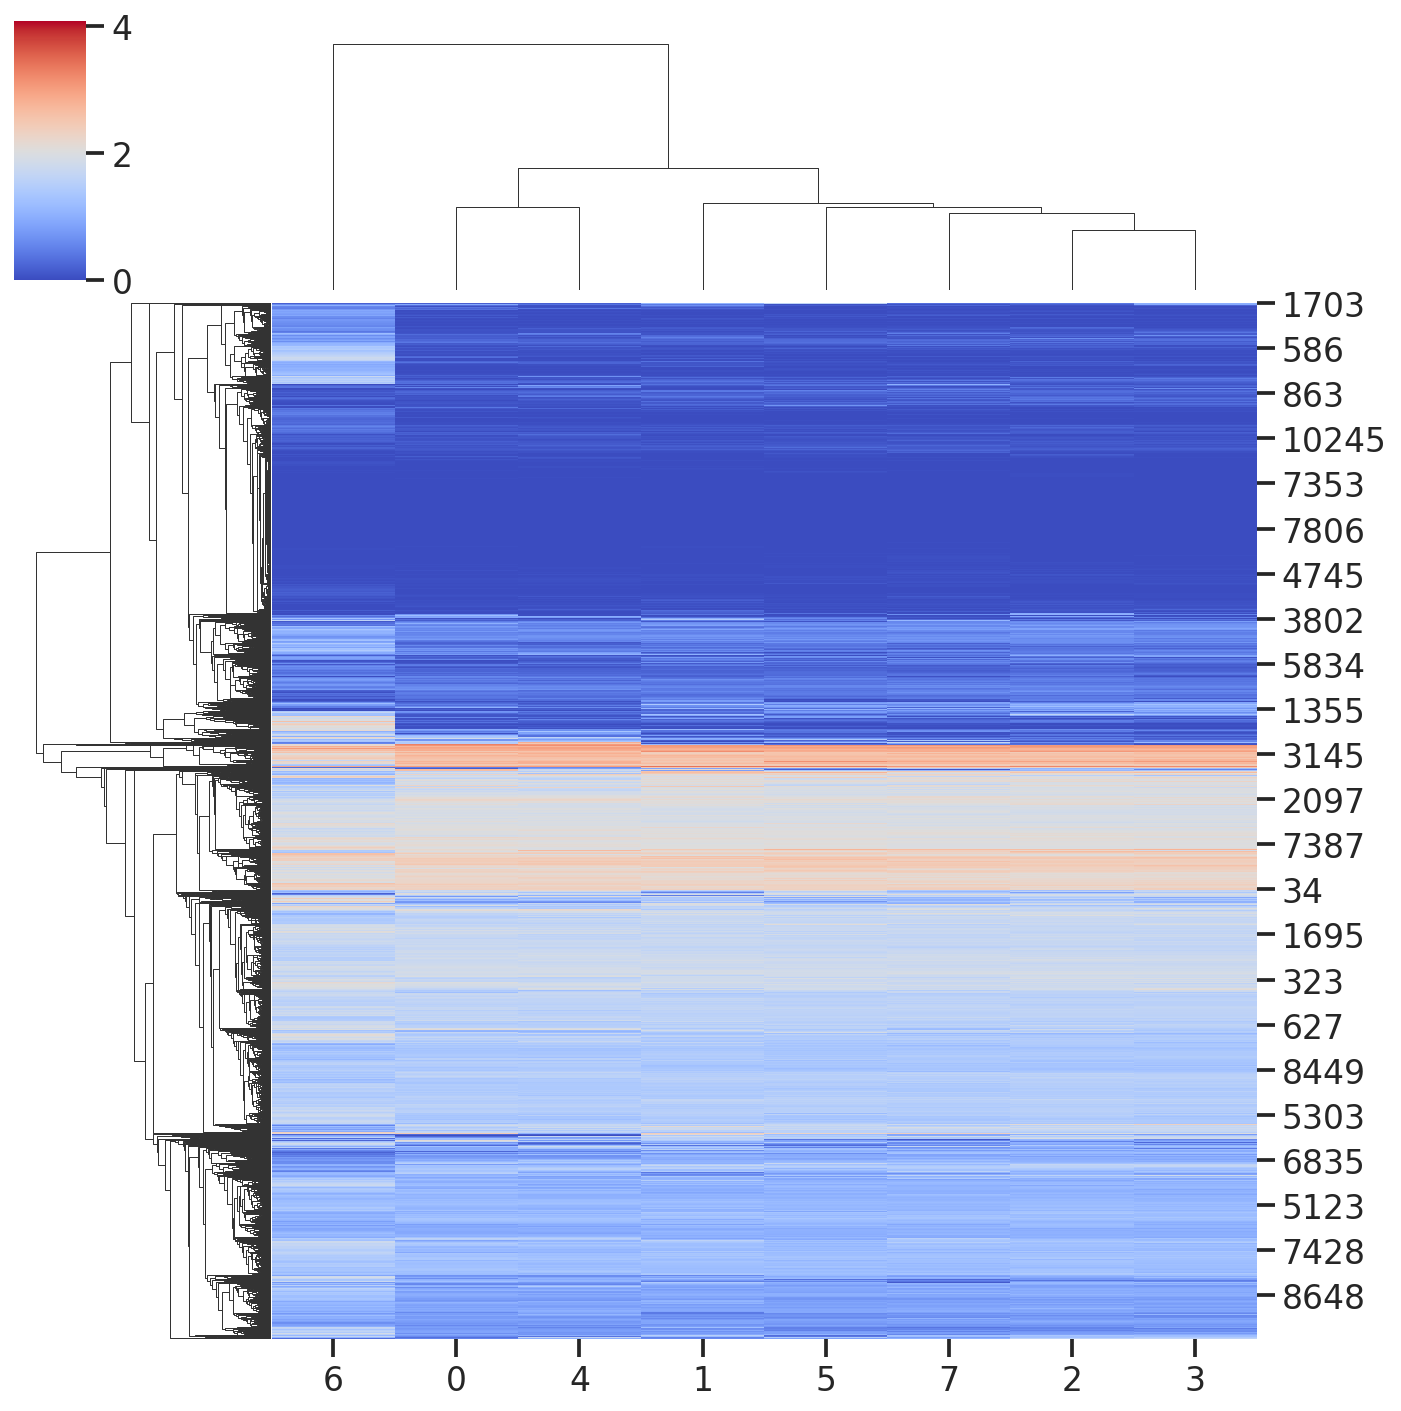

In [7]:
sns.clustermap(np.log10(ctrds_l2.T+1), cmap='coolwarm')

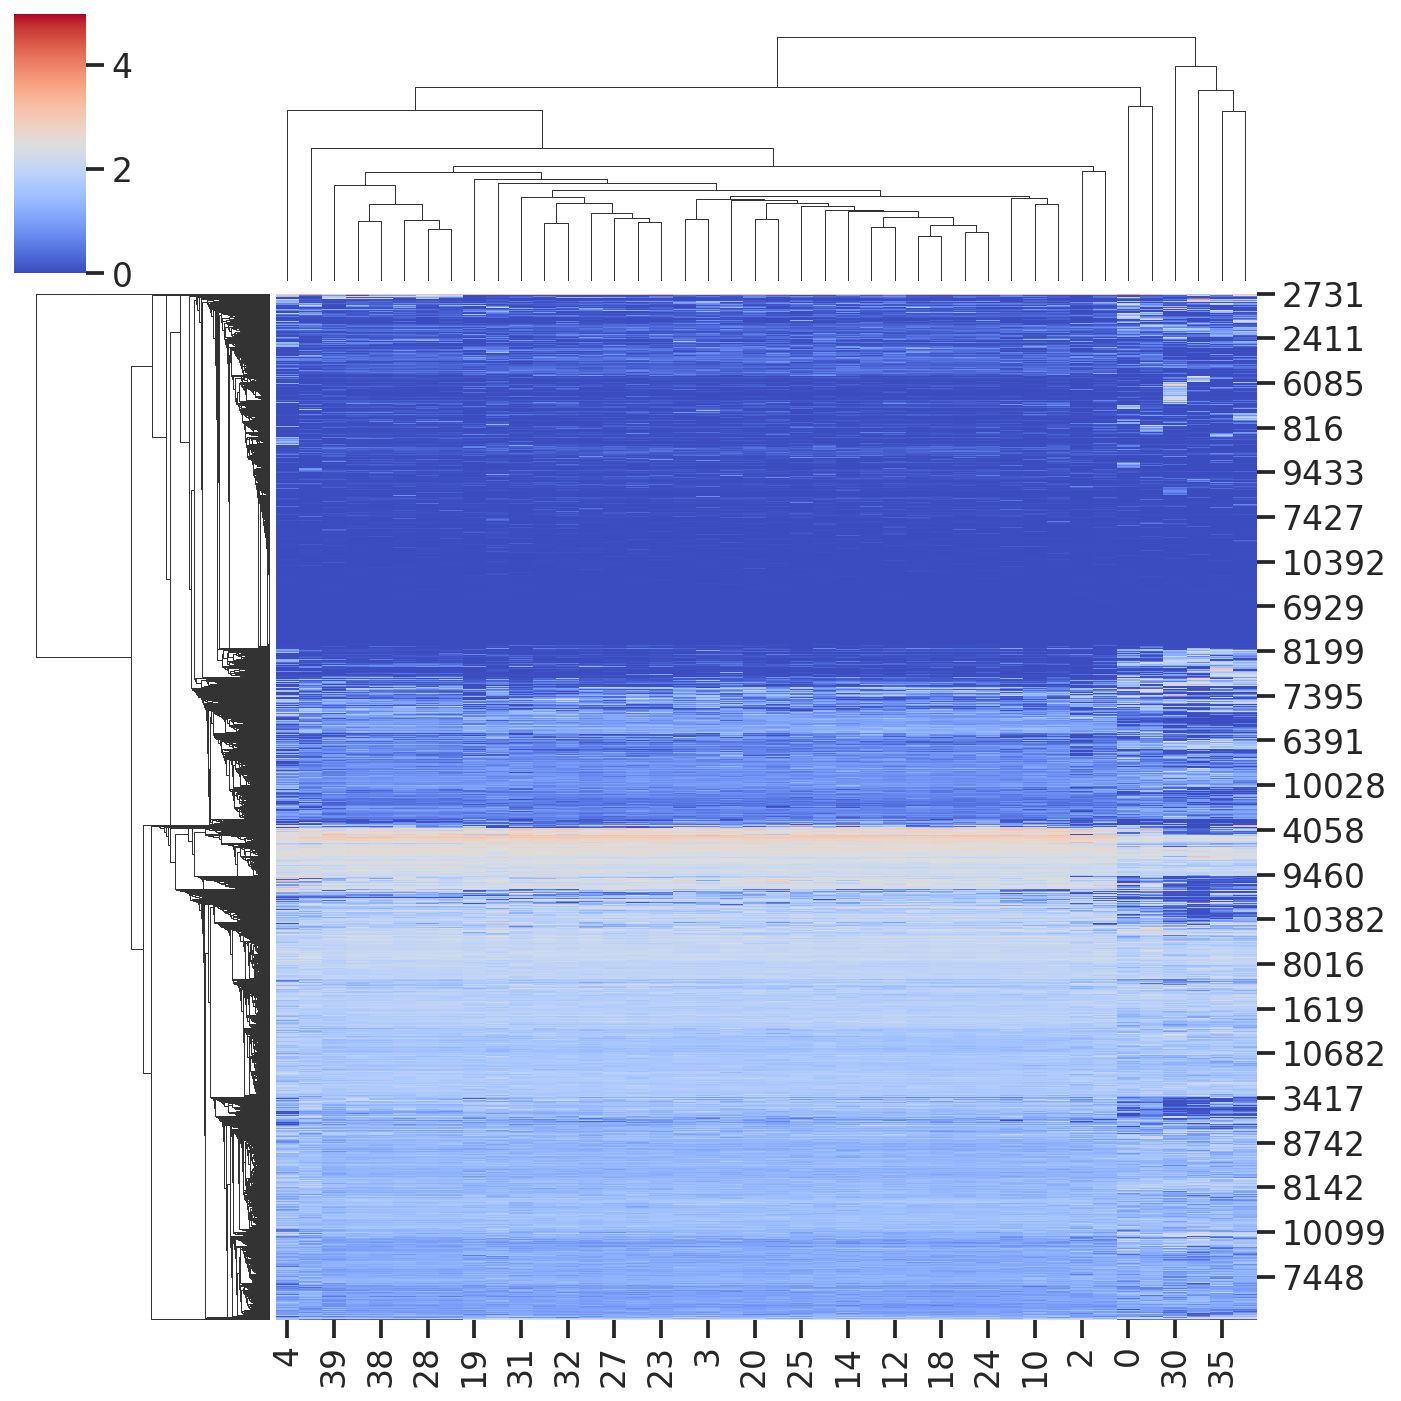

In [8]:
sns.clustermap(np.log10(ctrds_l3.T+1), cmap='coolwarm')

In [9]:
ctrds_l3.shape, ctrds_l1.shape
types_l3, types_l1

(array(['Astro', 'CA1-ProS', 'CA2-IG-FC', 'CA3', 'CR', 'CT SUB', 'Car3',
        'DG', 'Endo', 'L2 IT ENTl', 'L2 IT ENTm', 'L2/3 IT CTX',
        'L2/3 IT ENTl', 'L2/3 IT PPP', 'L2/3 IT RHP', 'L3 IT ENT',
        'L4 RSP-ACA', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PPP', 'L5 PT CTX',
        'L5/6 IT TPE-ENT', 'L5/6 NP CTX', 'L6 CT CTX', 'L6 IT CTX',
        'L6 IT ENTl', 'L6b CTX', 'L6b/CT ENT', 'Lamp5', 'Meis2',
        'Micro-PVM', 'NP PPP', 'NP SUB', 'Oligo', 'Pvalb', 'SMC-Peri',
        'SUB-ProS', 'Sncg', 'Sst', 'Sst Chodl', 'VLMC', 'Vip'],
       dtype=object),
 array(['GABAergic', 'Glutamatergic', 'Non-Neuronal'], dtype=object))

In [10]:
types_l3tol1 = meta.groupby('subclass_label')['class_label'].first().loc[types_l3].values
types_l3tol1_code, types_l1_ = pd.factorize(types_l3tol1, sort=True)
assert np.all(types_l1_ == types_l1)
ctrds_diff = ctrds_l3 - ctrds_l1[types_l3tol1_code]
print(ctrds_diff.shape)

(42, 10861)


In [17]:
# select to change exc cells only
ctrds_diff[types_l3tol1 == 'Glutamatergic'].shape #, # _code

(29, 10861)

In [24]:
cond = np.logical_or(types_l3tol1 == 'Glutamatergic', types_l3tol1 == 'GABAergic')
ctrds_diff[cond].shape

(36, 10861)

In [34]:
%%time
Sb = ctrds_diff.T.dot(ctrds_diff)
Sb.shape

CPU times: user 6.99 s, sys: 744 ms, total: 7.73 s
Wall time: 1.04 s


(10861, 10861)

In [42]:
%%time
# # # # run PNMF orig -- what we do and have to do
# w_pca, rec_pca = PNMF.get_PNMF(X[:,:1000].T, init='pca',     k=24, verbose=True, report_stride=30)
# w_p2x, rec_p2x = PNMF.get_PNMF(X.T, init='pca_2x',  k=24, verbose=True, report_stride=30)
# w_nrm, rec_nrm = PNMF.get_PNMF(X.T, init='normal',  k=24, verbose=True, report_stride=30)
w_uni, rec_uni = PNMF.get_PNMF(X[:,:1000].T, init='uniform', k=24, verbose=True, report_stride=30)

10-04 11:57:41 - 0, 7.61e-01
10-04 11:57:41 - 30, 4.63e-03
10-04 11:57:41 - 60, 2.71e-03
10-04 11:57:42 - 90, 9.90e-04
10-04 11:57:42 - 120, 5.06e-04
10-04 11:57:42 - 150, 4.56e-04
10-04 11:57:43 - 180, 1.64e-04
10-04 11:57:43 - 210, 7.72e-05
10-04 11:57:43 - 240, 4.95e-05
10-04 11:57:43 - 270, 4.87e-05
10-04 11:57:44 - 300, 5.21e-05
10-04 11:57:44 - 330, 4.40e-05
10-04 11:57:44 - 360, 3.27e-05
10-04 11:57:44 - 390, 2.54e-05
10-04 11:57:45 - 420, 2.01e-05
10-04 11:57:45 - 450, 1.55e-05
10-04 11:57:45 - 480, 1.22e-05
10-04 11:57:46 - 510, 1.01e-05


CPU times: user 2min 38s, sys: 7.44 s, total: 2min 45s
Wall time: 5.52 s


In [47]:
w_uni_mu100, rec_uni_mu100 = PNMF.get_DPNMF(X[:,:1000].T, 24, -Sb[:1000,:1000], 100,
                                            init='uniform', verbose=True, report_stride=30)

10-04 11:58:18 - 0, 7.60e-01
10-04 11:58:19 - 30, 6.34e-03
10-04 11:58:19 - 60, 3.15e-03
10-04 11:58:19 - 90, 1.03e-03
10-04 11:58:20 - 120, 5.35e-04
10-04 11:58:20 - 150, 4.53e-04
10-04 11:58:20 - 180, 1.40e-04
10-04 11:58:20 - 210, 9.01e-05
10-04 11:58:21 - 240, 6.27e-05
10-04 11:58:21 - 270, 5.84e-05
10-04 11:58:21 - 300, 5.18e-05
10-04 11:58:22 - 330, 4.03e-05
10-04 11:58:22 - 360, 3.27e-05
10-04 11:58:22 - 390, 2.68e-05
10-04 11:58:23 - 420, 2.10e-05
10-04 11:58:23 - 450, 1.58e-05
10-04 11:58:23 - 480, 1.20e-05


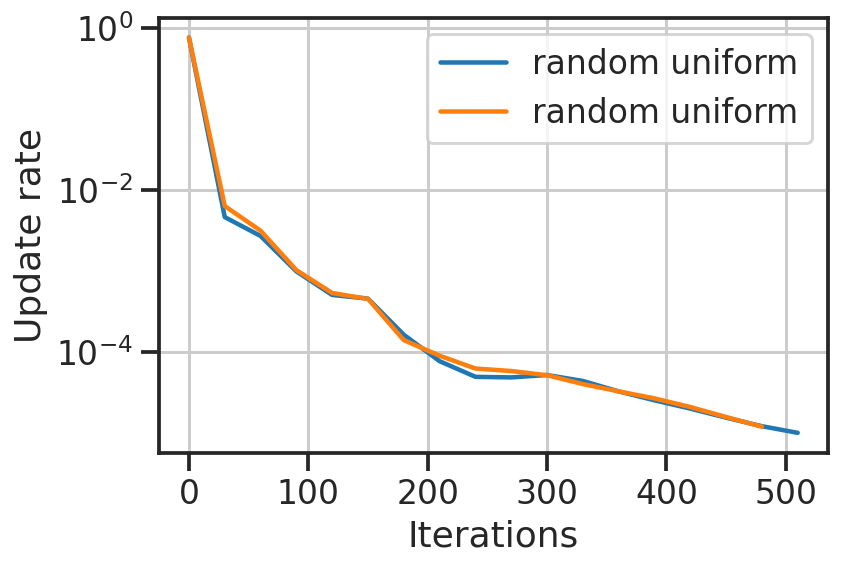

In [49]:
# plt.plot(rec_pca[:,0], rec_pca[:,1], label='pca')
# plt.plot(rec_p2x[:,0], rec_p2x[:,1], label='pca_2x')
# plt.plot(rec_nrm[:,0], rec_nrm[:,1], label='random normal')
plt.plot(rec_uni[:,0], rec_uni[:,1], label='random uniform')
plt.plot(rec_uni_mu1[:,0], rec_uni_mu1[:,1], label='random uniform')
plt.xlabel('Iterations')
plt.ylabel('Update rate')
plt.legend()
plt.yscale('log')
# plt.xscale('log')

In [7]:
def plot(w, ax, vmax=None, reorder=True):
    if reorder:
        wnew, rows, cols = basicu.diag_matrix_rows(w)
    else:
        wnew = w
        
    sns.heatmap(
                # np.log10(wnew+1), 
                wnew,
                ax=ax, 
                cmap='rocket_r', 
                cbar_kws=dict(shrink=0.5),
                vmax=vmax,
               )

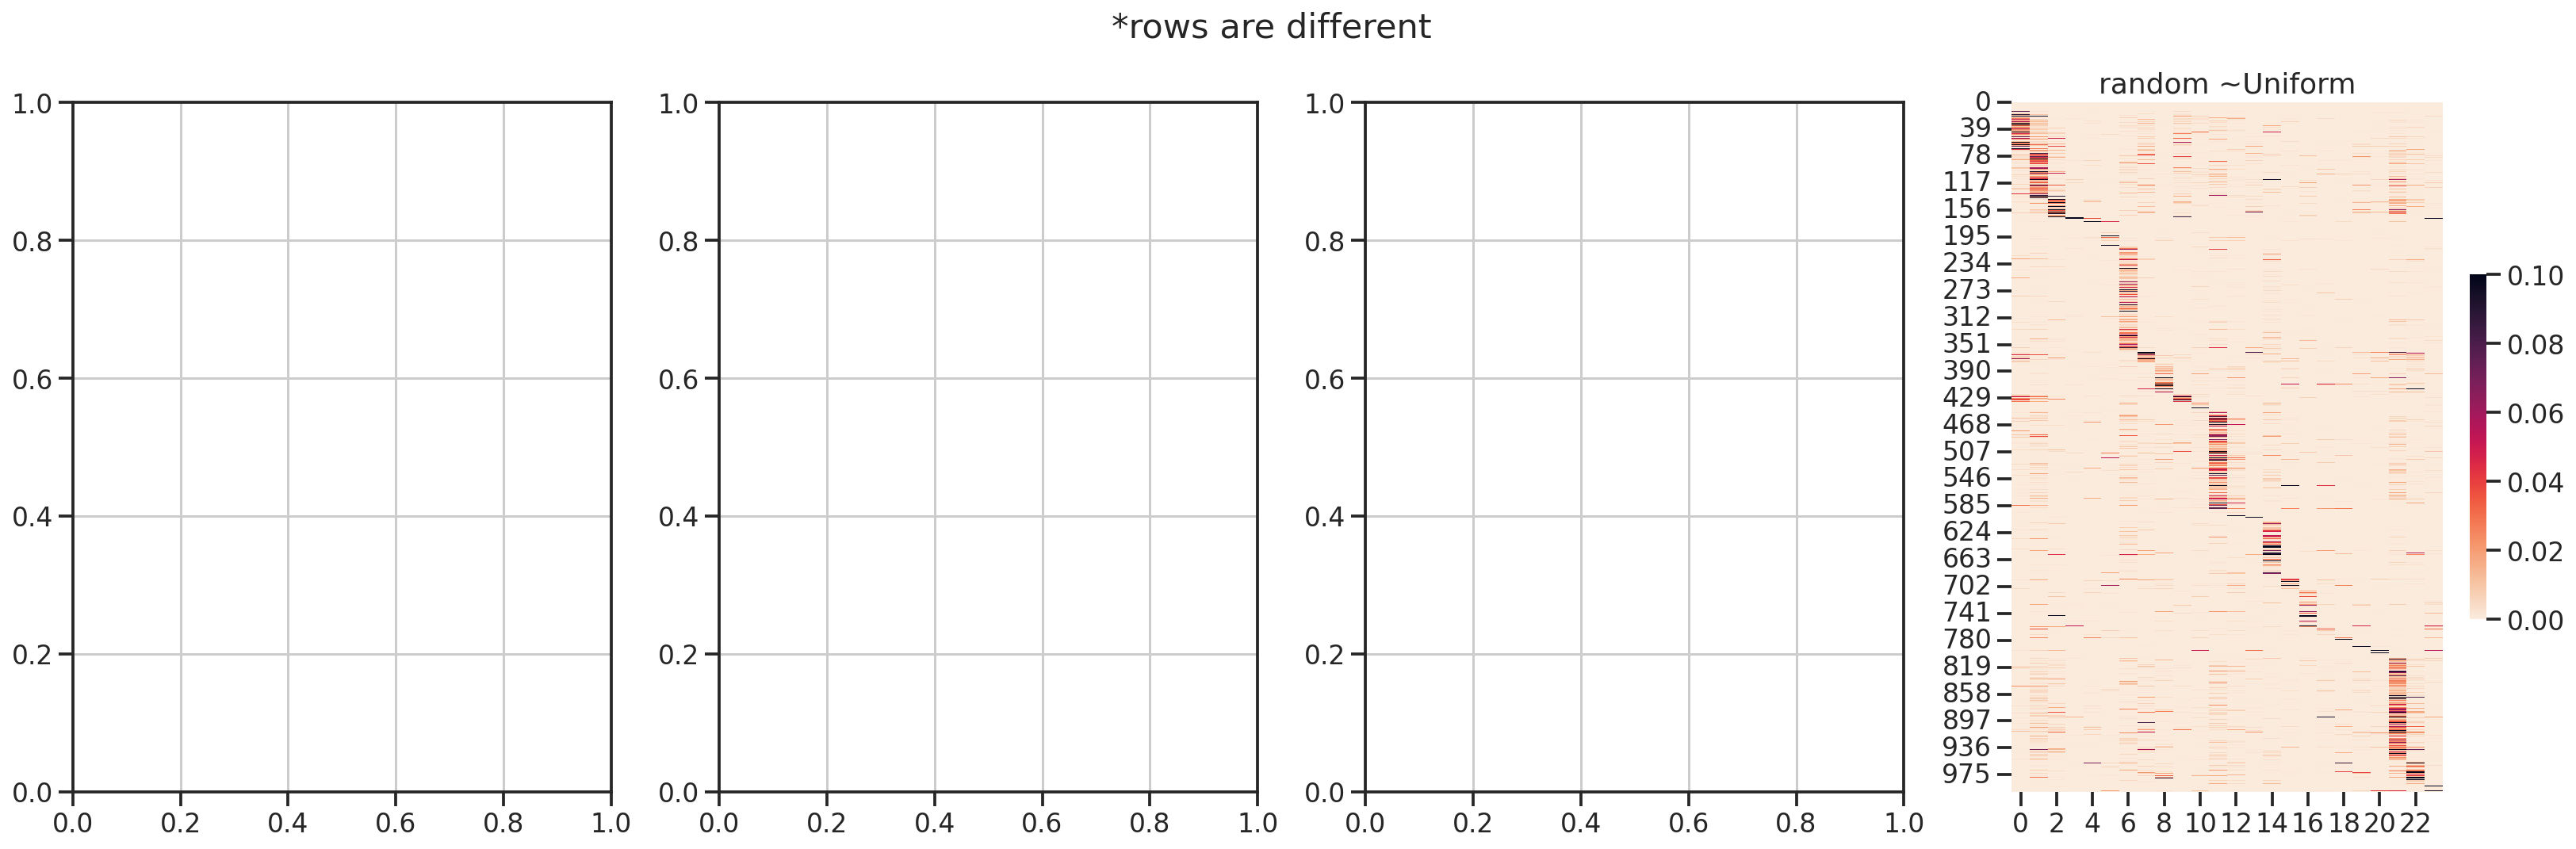

In [8]:
vmax = 0.1
# vmax = 0.03
fig, axs = plt.subplots(1, 4, figsize=(7*4,8))
# ax = axs[0]
# plot(w_pca, ax, vmax=vmax)
# ax.set_title('|PCA|')

# ax = axs[1]
# plot(w_p2x, ax, vmax=vmax)
# ax.set_title('PCA 2x')

# ax = axs[2]
# plot(w_nrm, ax, vmax=vmax)
# ax.set_title('random |~Normal|')

ax = axs[3]
plot(w_uni, ax, vmax=vmax)
ax.set_title('random ~Uniform')
fig.suptitle('*rows are different')
plt.show()

In [9]:
vmax = 0.1
# vmax = 0.03
# set the order
wnew, rows, cols = basicu.diag_matrix_rows(w_pca)
# wnew, rows, cols = basicu.diag_matrix_rows(w_p2x)

fig, axs = plt.subplots(1, 4, figsize=(7*4,8))
ax = axs[0]
wnew = w_pca[rows]
plot(wnew, ax, vmax=vmax, reorder=False)
ax.set_title('|PCA|')

ax = axs[1]
wnew = w_p2x[rows]
plot(wnew, ax, vmax=vmax, reorder=False)
ax.set_title('PCA 2x')

ax = axs[2]
wnew = w_nrm[rows]
plot(wnew, ax, vmax=vmax, reorder=False)
ax.set_title('random |~Normal|')

ax = axs[3]
wnew = w_uni[rows]
plot(wnew, ax, vmax=vmax, reorder=False)
ax.set_title('random ~Uniform')

fig.suptitle('*rows are aligned')
plt.show()

NameError: name 'w_pca' is not defined

# save and validate these


In [ ]:
output = os.path.join(res_dir, "smrt_X_v2_DPNMF.h5ad")
res_adata = anndata.AnnData(w_pca)
res_adata.layers['w_pca'] = w_pca
res_adata.layers['w_p2x'] = w_p2x
res_adata.layers['w_nrm'] = w_nrm
res_adata.layers['w_uni'] = w_uni
res_adata

In [ ]:
res_adata.write(output)

In [ ]:
b = anndata.read(output)
b